In [1]:
import os
import json
import pandas as pd

from dbfread import DBF
import geopandas as gpd
from shapely.geometry import Point, MultiPoint

from config import CRS

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
dict_code_regbl = {}
ext_data_folder = os.path.join("data", "external", "code_regbl")
for file in os.listdir(ext_data_folder):
    key = file.split(".")[0].split("_")[-1]
    
    with open(os.path.join(ext_data_folder, file)) as json_file:
        dict_code_regbl[key] = {int(k): v for k, v in json.load(json_file).items()}

In [3]:
%matplotlib notebook
data_folder = os.path.join("data", "raw")

In [4]:
dbf = DBF(os.path.join(data_folder, "BesoinsFuturs_existingBdg.dbf"))
df = pd.DataFrame(iter(dbf))

cols_to_keep = [
    "ID_Bat",
    "ID_Concept",
    "EA_Heat",
    "EA_HW",
    "HeatPower",
    "Need_Heat",
    "Need_HW",
    "SRE",
    "TempLevel_",
    "Allocation",
    "Epoch",
]
df = df[cols_to_keep]
df.rename(columns={"TempLevel_": "TempLevel", "ID_Bat": "ID_bat"}, inplace=True)

df = df.loc[df.HeatPower > 0]
df.HeatPower = df.HeatPower.apply(float)

df.reset_index(inplace=True, drop=True)

df = df.loc[df.Allocation > 0]
df = df.loc[df.Allocation < 13]
df["SIA"] = df.Allocation

df.replace({"EA_Heat": dict_code_regbl["ea"], "EA_HW": dict_code_regbl["ea"]}, inplace=True)
df.replace({"Allocation": dict_code_regbl["al"], "Epoch": dict_code_regbl["ep"]}, inplace=True)

df.head(2)

ID_bat  ID_Concept EA_Heat  EA_HW  HeatPower      Need_Heat       Need_HW  \
0       8           0     gas    gas       84.0  120228.496894  40130.033035   
1      16           0   other  other       11.0   19659.863597    990.071041   

          SRE  TempLevel             Allocation        Epoch  SIA  
0  477.738489         70  indoor swimming pools            0   12  
1  141.580300         70         administration  .... - 1919    3

In [5]:
gdf = gpd.read_file(os.path.join(data_folder, "Chaudieres", "Chaudieres.shp")).to_crs(crs=CRS).loc[:, ["ID_bat", "geometry"]]
gdf.set_index("ID_bat", inplace=True, drop=True)
gdf.head(2)

geometry
ID_bat                                                   
2       POLYGON ((335033.7596584351 5147059.995174269,...
3       POLYGON ((335032.3302442689 5147079.338028543,...

In [6]:
data = pd.merge(gdf, df, how="right", on="ID_bat")
data.dropna(inplace=True)
data.head(2)

ID_bat                                           geometry  ID_Concept  \
0       8  POLYGON ((333618.3162912441 5148286.238886707,...           0   
1      16  POLYGON ((333781.8668657038 5148335.068558921,...           0   

  EA_Heat  EA_HW  HeatPower      Need_Heat       Need_HW         SRE  \
0     gas    gas       84.0  120228.496894  40130.033035  477.738489   
1   other  other       11.0   19659.863597    990.071041  141.580300   

   TempLevel             Allocation        Epoch  SIA  
0         70  indoor swimming pools            0   12  
1         70         administration  .... - 1919    3

In [7]:
points = []
filepath = os.path.join("data", "raw", "RE", "network.txt")

with open(filepath) as fp:
    line = fp.readline()
    while line:
        if "HEADNODES" in line:
            break
        if "SPOTLOAD" in line:
            x, y = line.split(",")[1:3]
            if float(x) < 700000:
                points.append((float(x), float(y)))
        line = fp.readline()

spotloads = gpd.GeoDataFrame(geometry=[Point(xy) for xy in points], crs={'init': 'epsg:21781'}).to_crs(crs=CRS)
grid_hull = MultiPoint(spotloads.geometry.values).convex_hull

In [8]:
idx_buildings_grid = [idx for idx, poly in data.geometry.iteritems() if poly.intersection(grid_hull).area > 0]
data["GridArea"] = 0
data.loc[idx_buildings_grid, "GridArea"] = 1

In [9]:
def surf_pv(poly):
    s = poly.area
    if s > 500:
        s *= 0.7
    else:
        s *= 0.4
    
    return round(s)
        
data['MaxSurf_PV_m2'] = data['geometry'].apply(surf_pv)

In [10]:
filename = 'SIA2024to380-1.csv'
df_380 = pd.read_csv(os.path.join("data", "external", filename), index_col=0)
df_380['cool_elec'] = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

df_380.set_index("nom", inplace=True)

def cooling_power(row):
    p_norm = df_380.loc[row['Allocation'], 'th_cool']
    elec_cooling = df_380.loc[row['Allocation'], 'cool_elec']
    return elec_cooling*round(row['SRE'] * p_norm * 1e-3)

data['CoolPower'] = data.apply(cooling_power, axis=1)
data.head(2)

ID_bat                                           geometry  ID_Concept  \
0       8  POLYGON ((333618.3162912441 5148286.238886707,...           0   
1      16  POLYGON ((333781.8668657038 5148335.068558921,...           0   

  EA_Heat  EA_HW  HeatPower      Need_Heat       Need_HW         SRE  \
0     gas    gas       84.0  120228.496894  40130.033035  477.738489   
1   other  other       11.0   19659.863597    990.071041  141.580300   

   TempLevel             Allocation        Epoch  SIA  GridArea  \
0         70  indoor swimming pools            0   12         0   
1         70         administration  .... - 1919    3         0   

   MaxSurf_PV_m2  CoolPower  
0            418        1.0  
1             71        3.0

<IPython.core.display.Javascript object>


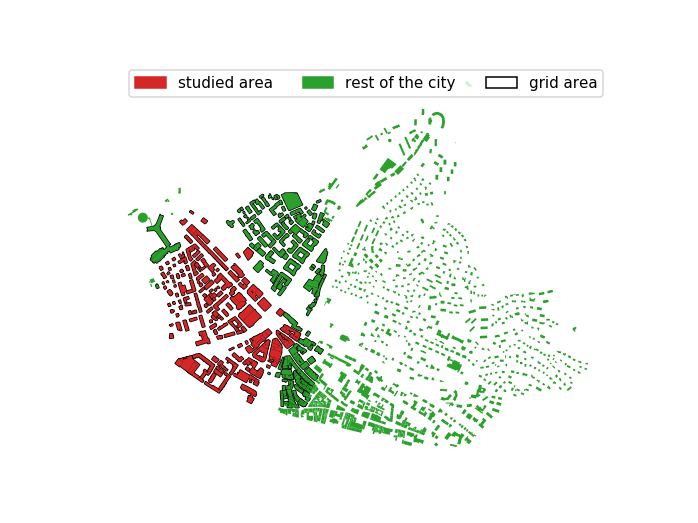

In [11]:
fig, ax = plt.subplots()
ax.axis("off")
data.loc[data.GridArea == 1].plot(ax=ax, color="white", edgecolor="black")
data.loc[data.ID_Concept != 12].plot(ax=ax, color="C2")
data.loc[data.ID_Concept == 12].plot(ax=ax, color="C3")

rest_of_city = mpatches.Patch(color="C2", label="rest of the city")
studied_area = mpatches.Patch(color="C3", label="studied area")
grid_area = mpatches.Patch(facecolor="white", edgecolor="black", label="grid area")

ax.legend(handles=[studied_area, rest_of_city, grid_area], ncol=3)
plt.savefig(os.path.join("images", "studied_area.png"), dpi=150, bbox_inches="tight")

In [12]:
filepath = os.path.join("data", "processed", "buildings.gpkg")
data.to_file(filepath, driver="GPKG")